# Analysis of the online model

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

### Results with number of repeats

In [2]:
folder = '../data/online'
filenames = sorted(os.listdir(folder))
for filename in filenames:
    if 'online' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

online_alibaba_s4_dt07-27_14-33-45.json: 20
online_synthetic_s4_dt06-29_13-26-32.json: 20
online_synthetic_s4_dt07-09_10-49-53.json: 20
online_synthetic_s6_dt07-01_16-24-33.json: 4
online_synthetic_s6_dt07-09_10-49-53.json: 20


## Online resource allocation

In [3]:
results_filename = f'{folder}/online_synthetic_s4_dt07-09_10-49-53.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [4]:
batch_lengths = [batch_length for batch_length in results_data[0].keys() if batch_length != 'model']
algos = list(results_data[0]['batch length 1'].keys())
greedy_name = algos[1]
algo_names = ['Non-elastic Optimal', 'Greedy Algorithm']
{'Batch length': batch_lengths, 'Algorithms': algos, 'Algo Names': algo_names}

{'Batch length': ['batch length 1', 'batch length 3', 'batch length 6'],
 'Algorithms': ['Non-elastic Optimal',
  'Greedy Utility * deadline / Sum, Product, Pow percent sum'],
 'Algo Names': ['Non-elastic Optimal', 'Greedy Algorithm']}

### Task arrival over time

In [5]:
model_tasks = results_data[0]['model']['tasks']
max_auction_time = max(task['auction time'] for task in model_tasks) + 1
max_auction_time

250

(0.0, 250.0)

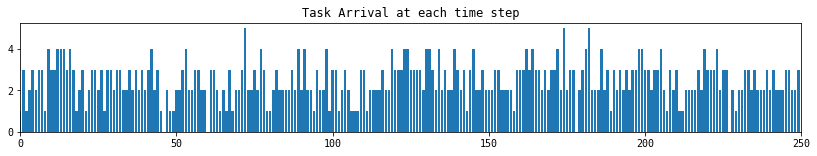

In [6]:
tasks_per_time_step = [
    sum(task['auction time'] == time_step for task in model_tasks)
    for time_step in range(max_auction_time)
]

_, ax_task_arrival = plt.subplots(figsize=(14, 2))
ax_task_arrival.bar(np.arange(max_auction_time), tasks_per_time_step)
ax_task_arrival.set_title('Task Arrival at each time step')
ax_task_arrival.set_xlim(0, max_auction_time)

### Server resource usage over time

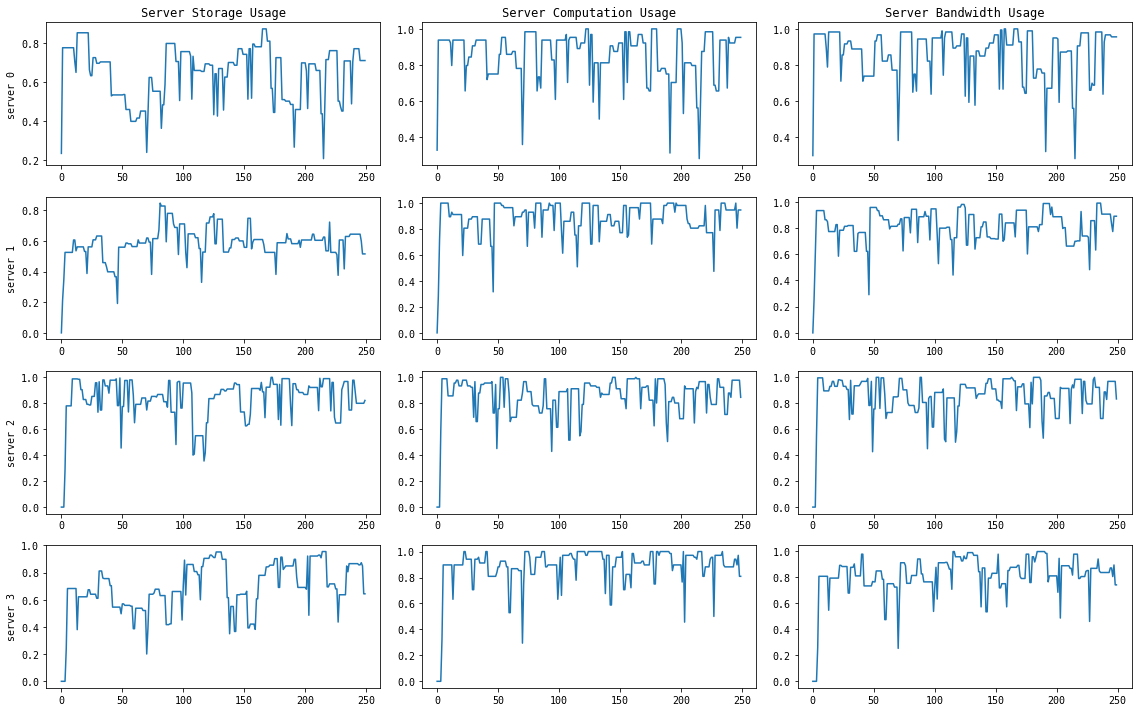

In [7]:
servers = list(results_data[0]['batch length 1']['Non-elastic Optimal']['server storage used'].keys())

fig, axs = plt.subplots(len(servers), 3, figsize=(16, 10))
for pos, title in enumerate(('Server Storage Usage', 'Server Computation Usage', 'Server Bandwidth Usage')):
    axs[0][pos].set_title(title)
    
for ax, server in zip(axs, servers):
    ax[0].set_ylabel(server)
    batch_time_steps = len(results_data[0]['batch length 1'][algos[1]]['server storage used'][server])
    for resource_ax, resource in zip(ax, ('server storage used', 'server computation used', 'server bandwidth used')):
        resource_ax.plot(np.arange(batch_time_steps), results_data[0]['batch length 1'][algos[1]][resource][server])
        
plt.tight_layout()

## Overall results

In [8]:
for filename in filenames:
    print(f'\n{filename}')
    with open(f'{folder}/{filename}') as file:
        results_data = json.load(file)
    
    if greedy_name in results_data[0]:
        # Read file in new format
        algos = [algo for algo in results_data[0] if algo != 'model']
        for algo in algos:
            performance = lambda param: np.mean([result[algo][param] for result in results_data])
            print(f'\t{algo} - Tasks allocated: {performance("percentage tasks allocated"):.3f}, ' \
                  f'social welfare: {performance("social welfare"):.3f}, ' \
                  f'social welfare percentage: {performance("social welfare percent"):.3f}')
            
        diff = np.mean(np.divide(*[[result[algo]['social welfare'] for result in results_data] for algo in algos]))
        print(f'Performance difference: {diff:.3f}')
    else:
        # Read file in old format
        batch_lengths = [batch_length for batch_length in results_data[0].keys() if batch_length != 'model']
        algos = list(results_data[0][batch_lengths[0]].keys())
        for algo in algos:
            print(f'Algorithm: {algo}')
            for batch_length in batch_lengths:
                performance = lambda param: np.mean([result[batch_length][algo][param] for result in results_data])
                print(f'\t{batch_length} - Tasks allocated: {performance("percentage tasks allocated"):.3f}, ' \
                      f'social welfare percentage: {performance("social welfare percent"):.3f}')

        print('Performance difference - ', end='')
        for batch_length in batch_lengths:
            diff = np.mean(np.divide(*[[result[batch_length][algo]['social welfare'] for result in results_data] for algo in algos]))
            print(f'{batch_length.title()}: {diff:.3f}, ', end='')
        print()


online_alibaba_s4_dt07-27_14-33-45.json
	Non-elastic Optimal - Tasks allocated: 0.372, social welfare: 5310.300, social welfare percentage: 0.310
	Greedy Utility * deadline / Sum, Product, Pow percent sum - Tasks allocated: 0.409, social welfare: 5951.203, social welfare percentage: 0.347
Performance difference: 0.895

online_synthetic_s4_dt06-29_13-26-32.json
Algorithm: Non-elastic Optimal
	batch length 1 - Tasks allocated: 0.239, social welfare percentage: 0.275
	batch length 3 - Tasks allocated: 0.203, social welfare percentage: 0.256
	batch length 6 - Tasks allocated: 0.162, social welfare percentage: 0.213
Algorithm: Greedy Utility * deadline / Sum, Product, Pow percent sum
	batch length 1 - Tasks allocated: 0.354, social welfare percentage: 0.401
	batch length 3 - Tasks allocated: 0.296, social welfare percentage: 0.366
	batch length 6 - Tasks allocated: 0.235, social welfare percentage: 0.297
Performance difference - Batch Length 1: 0.679, Batch Length 3: 0.692, Batch Length 6:

### Synthetic results over batch lengths

In [9]:
results_filename = f'{folder}/online_synthetic_s4_dt06-29_13-26-32.json'

print(results_filename)
with open(results_filename) as file:
    results_data = json.load(file)

../data/online/online_synthetic_s4_dt06-29_13-26-32.json


In [10]:
data = [] 
batch_lengths = [batch_length for batch_length in results_data[0].keys() if 'model' not in batch_length]
for pos, result in enumerate(results_data):
    for length, length_name in zip(batch_lengths, ('Online', 'Batch Length=3', 'Batch Length=6')):
        for algo, algo_name in zip(algos, algo_names):
            data.append([length_name, algo_name, result[length][algo]['social welfare'], pos])
    
online_df = pd.DataFrame(data, columns=['Batch Length', 'Algorithm', 'Social Welfare', 'repeat'])
online_df.replace('Non-elastic Optimal', 'Non-elastic Myopic Optimal', inplace=True)

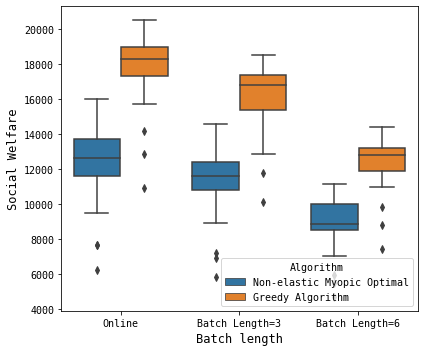

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='Batch Length', y='Social Welfare', hue='Algorithm', data=online_df, ax=ax)
ax.set_xlabel('Batch length', fontsize=12)
ax.set_ylabel('Social Welfare', fontsize=12)
plt.tight_layout()

## Synthetic and Alibaba online modelling

Save file location: figs/eps/online_resource_allocation.eps
Save file location: figs/png/online_resource_allocation.png
Save file location: figs/pdf/online_resource_allocation.pdf


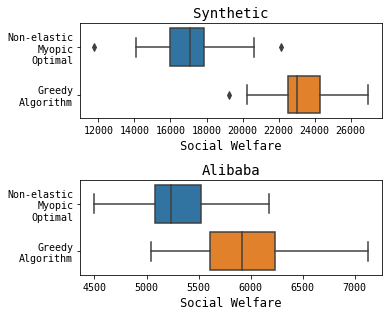

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(5.5, 4.5))
for filename, model, ax in [['online_synthetic_s6_dt07-09_10-49-53.json', 'Synthetic', axs[0]], 
                            ['online_alibaba_s4_dt07-27_14-33-45.json', 'Alibaba', axs[1]]]:
    with open(f'{folder}/{filename}') as file:
        results_data = json.load(file)
        
    data = []
    for pos, result in enumerate(results_data):
        for algo, algo_name in zip(algos, algo_names):
            if 'batch length 1' in result:
                data.append([model, algo_name, result['batch length 1'][algo]['social welfare'], pos])
            else:
                data.append([model, algo_name, result[algo]['social welfare'], pos])
    
    online_df = pd.DataFrame(data, columns=['Model', 'Algorithm', 'Social Welfare', 'repeat'])
    online_df.replace('Non-elastic Optimal', 'Non-elastic\nMyopic\nOptimal', inplace=True)
    online_df.replace('Greedy Algorithm', 'Greedy\nAlgorithm', inplace=True)
    
    sns.boxplot(y='Algorithm', x='Social Welfare', data=online_df, ax=ax)
    ax.set_title(model, fontsize=14)
    ax.set_ylabel('')
    ax.set_xlabel('Social Welfare', fontsize=12)

plt.tight_layout()
save_plot('online_resource_allocation')